<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/titanic_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install keras_tuner ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 9.1 MB/s eta 0:00:00


In [ ]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv
!ls -al data
!wc -l data/*.csv

2025-03-31 03:13:17 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_13_End_to_end_example/titanic.csv [61194/61194] -> "data/titanic.csv" [1]
total 68
drwxr-xr-x 2 root root  4096 Mar 31 03:13 .
drwxr-xr-x 1 root root  4096 Mar 31 03:13 ..
-rw-r--r-- 1 root root 61194 Mar 31 03:13 titanic.csv
892 data/titanic.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Preprocess Data

See data dictionary in [https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/input]

In [ ]:
df = pd.read_csv('./data/titanic.csv') #, index_col='PassengerId')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## drop columns

drop columns that are unique per record.

In [ ]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

## deal with NaN fields

In [ ]:
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687
Embarked,2


In [ ]:
# Cabin has too many NaN records, drop it
df = df.drop(['Cabin'], axis=1)

A better way to fill in the NaN Age is to use average age per Pclass because there seem to have clear patterns of it.

<Axes: xlabel='Pclass', ylabel='Age'>

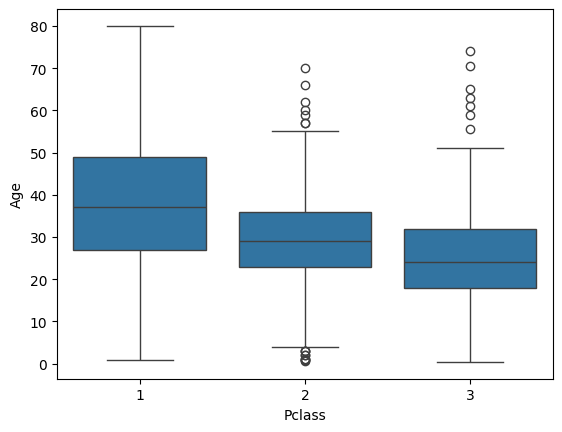

In [ ]:
sns.boxplot(x='Pclass', y='Age', data=df)

In [ ]:
fill_in_ages = df.groupby('Pclass')['Age'].mean()
fill_in_ages

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


In [ ]:
fill_in_ages[fill_in_ages.index==1].values[0]

np.float64(38.233440860215055)

In [ ]:
def fill_ages(x):
  if x.isna()['Age']: # x is Series, so we cannot use x['Age'].isna()
    x['Age'] = fill_in_ages[fill_in_ages.index==x['Pclass']].values[0]
    # print('replacing:', x['Age'])

  return x['Age']

In [ ]:
# use median age for missing Age
# df['Age'] = df['Age'].fillna( df['Age'].median() )
df['Age'] = df.apply(fill_ages, axis=1)
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,2


In [ ]:
# for the unknow embarked port, put U for unknown
df['Embarked'] = df['Embarked'].fillna('U')
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


In [ ]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.00000,1,0,7.2500,S
1,1,1,female,38.00000,1,0,71.2833,C
2,1,3,female,26.00000,0,0,7.9250,S
3,1,1,female,35.00000,1,0,53.1000,S
4,0,3,male,35.00000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.00000,0,0,13.0000,S
887,1,1,female,19.00000,0,0,30.0000,S
888,0,3,female,25.14062,1,2,23.4500,S
889,1,1,male,26.00000,0,0,30.0000,C


## categorise data

        Survival Count  Mortality Count  Survaval Ratio %
Pclass                                                   
1                  136               80         62.962963
2                   87               97         47.282609
3                  119              372         24.236253


<Figure size 300x200 with 0 Axes>

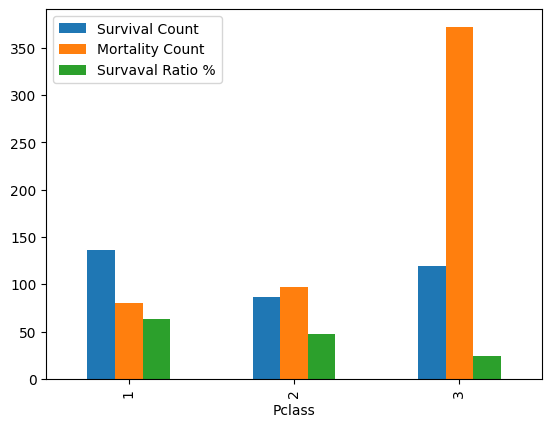

In [ ]:
# Pclass

# calculate survival rate of each pclass:
pclass_survival_count = df.query('Survived == 1')['Pclass'].value_counts().sort_index()
pclass_mortal_count = df.query('Survived == 0')['Pclass'].value_counts().sort_index()
pclass_survival_ratio = pclass_survival_count / (pclass_survival_count + pclass_mortal_count) * 100

pclass_stats = pd.concat([pclass_survival_count, pclass_mortal_count, pclass_survival_ratio],
                         keys=['Survival Count', 'Mortality Count', 'Survaval Ratio %'], axis=1)
print(pclass_stats)

plt.figure(figsize=(3,2))
pclass_stats.plot(kind='bar')
plt.show()

By the look of the above, there seems to have some ordinality of Pclass on survival rate. So leave it as is.

In [ ]:
# Sex only has 2 values, so turn them into 0 or 1
df['Sex'] = df['Sex'].astype('category').cat.codes
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.00000,1,0,7.2500,S
1,1,1,0,38.00000,1,0,71.2833,C
2,1,3,0,26.00000,0,0,7.9250,S
3,1,1,0,35.00000,1,0,53.1000,S
4,0,3,1,35.00000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,1,27.00000,0,0,13.0000,S
887,1,1,0,19.00000,0,0,30.0000,S
888,0,3,0,25.14062,1,2,23.4500,S
889,1,1,1,26.00000,0,0,30.0000,C


In [ ]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked']

for var in categorical:
  df = pd.concat([df, pd.get_dummies(df[var], prefix=var, dtype='long')], axis=1)
  del df[var]

In [ ]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
0,0,3,1,22.00000,1,0,7.2500,0,0,1,0
1,1,1,0,38.00000,1,0,71.2833,1,0,0,0
2,1,3,0,26.00000,0,0,7.9250,0,0,1,0
3,1,1,0,35.00000,1,0,53.1000,0,0,1,0
4,0,3,1,35.00000,0,0,8.0500,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.00000,0,0,13.0000,0,0,1,0
887,1,1,0,19.00000,0,0,30.0000,0,0,1,0
888,0,3,0,25.14062,1,2,23.4500,0,0,1,0
889,1,1,1,26.00000,0,0,30.0000,1,0,0,0


## scale continous columns

In [ ]:
## scale continuous columns

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cont = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

for c in cont:
  df[c] = df[c].astype('float64')
  df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

In [ ]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.0,-8.772133e-17,1.000562,-1.566107,-0.369365,0.827377,0.827377,0.827377
Sex,891.0,6.475870e-01,0.477990,0.000000,0.000000,1.000000,1.000000,1.000000
Age,891.0,9.968332e-17,1.000562,-2.186823,-0.552360,-0.249401,0.583736,3.840543
SibSp,891.0,4.386066e-17,1.000562,-0.474545,-0.474545,-0.474545,0.432793,6.784163
Parch,891.0,5.382900e-17,1.000562,-0.473674,-0.473674,-0.473674,-0.473674,6.974147
Fare,891.0,3.987333e-18,1.000562,-0.648422,-0.489148,-0.357391,-0.024246,9.667167
Embarked_C,891.0,1.885522e-01,0.391372,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,891.0,8.641975e-02,0.281141,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_S,891.0,7.227834e-01,0.447876,0.000000,0.000000,1.000000,1.000000,1.000000


In [ ]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_U
0,0,0.827377,1,-0.552360,0.432793,-0.473674,-0.502445,0,0,1,0
1,1,-1.566107,0,0.659475,0.432793,-0.473674,0.786845,1,0,0,0
2,1,0.827377,0,-0.249401,-0.474545,-0.473674,-0.488854,0,0,1,0
3,1,-1.566107,0,0.432256,0.432793,-0.473674,0.420730,0,0,1,0
4,0,0.827377,1,0.432256,-0.474545,-0.473674,-0.486337,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,-0.369365,1,-0.173662,-0.474545,-0.473674,-0.386671,0,0,1,0
887,1,-1.566107,0,-0.779579,-0.474545,-0.473674,-0.044381,0,0,1,0
888,0,0.827377,0,-0.314491,0.432793,2.008933,-0.176263,0,0,1,0
889,1,-1.566107,1,-0.249401,-0.474545,-0.473674,-0.044381,1,0,0,0


In [ ]:
df.to_csv('./data/preproc_data.csv', index=None)

## Split datasets

In [ ]:
df = pd.read_csv('./data/preproc_data.csv')
X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 10), (179, 10), (712,), (179,))

# Tensorflow model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_tfmodel(units=[8, 32], optimizer='adam', activation='linear',
                  init='glorot_uniform', dr=0.0):
  """ units: list of hidden layer dimensions
    optim: optimisation method
    activation: activation functions 'linear', 'relu', etc.
    init: kernel initialiser of layer
    dr: dropout rate
  """
  model = Sequential()
  # input layer
  model.add(Dense(units[0], input_dim=X_train.shape[1],
                  activation=activation, kernel_initializer=init))

  # hidden layers
  for dim in units[1:]:
    model.add(Dense(dim), activation=activation, kernel_initializer=init)

  model.add(Dropout(dr))

  # output layer
  model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model


In [ ]:
tf_model = build_tfmodel(units=[8], activation='relu')
tf_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf_train_result = tf_model.fit(X_train, y_train, batch_size=16, epochs=100,
                        validation_split=0.2, verbose=0)

acc = np.mean(tf_train_result.history['accuracy'])
loss = np.mean(tf_train_result.history['loss'])
val_acc = np.mean(tf_train_result.history['val_accuracy'])
val_loss = np.mean(tf_train_result.history['val_loss'])
print(f"  training accuracy: {acc:.4f}, loss: {loss:.4f}")
print(f"validation accuracy: {val_acc:.4f}, loss: {val_loss:.4f}")

  training accuracy: 0.7977, loss: 0.4557
validation accuracy: 0.8008, loss: 0.4487


In [ ]:
tf_train_result.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

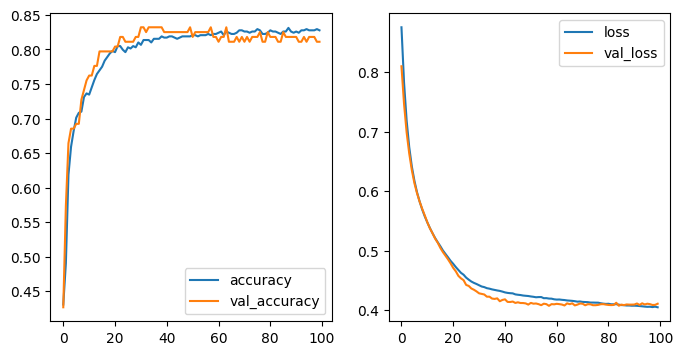

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(tf_train_result.history['accuracy'])
ax1.plot(tf_train_result.history['val_accuracy'])
ax1.legend(['accuracy', 'val_accuracy'])

ax2.plot(tf_train_result.history['loss'])
ax2.plot(tf_train_result.history['val_loss'])
ax2.legend(['loss', 'val_loss'])

plt.show()

In [ ]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Embarked_U'],
      dtype='object')

In [ ]:
input_weights = tf_model.get_layer('dense').get_weights()[0]
input_weights.sum(axis=1)

array([-1.0780456 ,  1.7511559 ,  0.67656225, -0.50654185,  0.6574602 ,
        2.0790539 , -0.32671154,  0.45990682,  0.8895176 ,  0.76707405],
      dtype=float32)

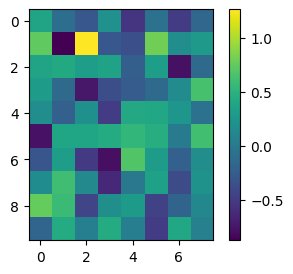

In [ ]:
# show weights
plt.figure(figsize=(4,3))
plt.imshow(input_weights)
plt.colorbar()
plt.show()

looking at columns 0 and 5 of above heatmap, the 2nd feature (Sex) has high weight, which makes sense: females survived more. Last feature is embark_U which has very low weight - it does not matter to survival.

In [ ]:
X.columns[input_weights[:,0].argsort()[::-1]]

Index(['Embarked_S', 'Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Embarked_Q',
       'Embarked_U', 'Embarked_C', 'Fare'],
      dtype='object')

In [ ]:
X.columns[input_weights[:,6].argsort()]

Index(['Age', 'Pclass', 'Embarked_Q', 'Embarked_C', 'Embarked_S', 'Fare',
       'SibSp', 'Sex', 'Parch', 'Embarked_U'],
      dtype='object')

In [ ]:
X.columns[input_weights.sum(axis=1).argsort()[::-1]]

Index(['Fare', 'Sex', 'Embarked_S', 'Embarked_U', 'Age', 'Parch', 'Embarked_Q',
       'Embarked_C', 'SibSp', 'Pclass'],
      dtype='object')

## Using Keras Tuner
[https://keras.io/keras_tuner/getting_started/]

In [ ]:
import keras_tuner

def build_ktmodel(hp):
  """ keras_tuner
  """
  init = hp.Choice("init", ['glorot_uniform', 'normal', 'uniform'])
  model = Sequential()
  # input layer
  model.add(Dense(units=hp.Int("units", min_value=8, max_value=64, step=16),
                  input_dim=X_train.shape[1],
                  activation=hp.Choice("activation", ["linear", "relu", "tanh"]),
                  kernel_initializer=init
                  )
            )
  model.add(Dropout(hp.Float("dr", min_value=0.0, max_value=0.5, step=0.1)))

  # hidden layers
  # for dim in units[1:]:
  #   model.add(Dense(dim), activation=activation, kernel_initializer=init)

  # model.add(Dropout(dr))

  # output layer
  model.add(Dense(1, activation='sigmoid',
                  kernel_initializer=init))

  model.compile(loss='binary_crossentropy',
                optimizer=hp.Choice("optimizer", ['adam', 'rmsprop']),
                metrics=['accuracy'])

  return model

# build_ktmodel(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_ktmodel,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
init (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['glorot_uniform', 'normal', 'uniform'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
dr (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Strictly speaking, the validation dataset should be used for hyperparameter tuning. Here is excerpt from NN and DL book:

To understand why, consider that when setting
hyper-parameters we’re likely to try many different choices for the hyper-parameters. If we
set the hyper-parameters based on evaluations of the test_data it’s possible we’ll end up
overfitting our hyper-parameters to the test_data. That is, we may end up finding hyperparameters which fit particular peculiarities of the test_data, but where the performance
of the network won’t generalize to other data sets. We guard against that by figuring out the
hyper-parameters using the validation_data. Then, once we’ve got the hyper-parameters
we want, we do a final evaluation of accuracy using the test_data. That gives us confidence
that our results on the test_data are a true measure of how well our neural network generalizes. To put it another way, you can think of the validation data as a type of training data that helps us learn good hyper-parameters. This approach to finding good hyper-parameters
is sometimes known as the **hold out method**, since the validation_data is kept apart or
“held out” from the training_data

In [ ]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Trial 3 Complete [00h 00m 54s]
val_accuracy: 0.8407821357250214

Best val_accuracy So Far: 0.8491619825363159
Total elapsed time: 00h 02m 36s


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
init: uniform
units: 8
activation: relu
dr: 0.1
optimizer: rmsprop
Score: 0.8491619825363159

Trial 1 summary
Hyperparameters:
init: glorot_uniform
units: 56
activation: tanh
dr: 0.2
optimizer: adam
Score: 0.8463687002658844

Trial 2 summary
Hyperparameters:
init: glorot_uniform
units: 56
activation: relu
dr: 0.30000000000000004
optimizer: adam
Score: 0.8407821357250214


In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_weights = best_model.get_layer('dense').get_weights()[0]
input_weights.sum(axis=1)

array([ 0.34410286,  1.2142677 ,  0.1710217 ,  0.20102203, -0.48708972,
       -0.20136824,  0.66004354,  0.5404064 ,  1.367001  ,  0.34979162],
      dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

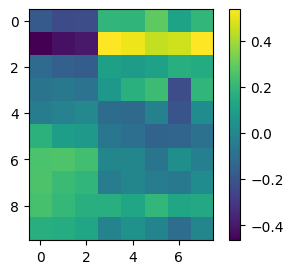

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(input_weights)
plt.colorbar()
plt.show

the plot clearly shows that the 2nd feature (Sex) is significant, followed by Pclass and Age.

In [ ]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Embarked_U'],
      dtype='object')

In [ ]:
X.columns[input_weights[:,0].argsort()[::-1]]

Index(['Embarked_Q', 'Embarked_C', 'Embarked_S', 'Fare', 'Embarked_U', 'Parch',
       'SibSp', 'Age', 'Pclass', 'Sex'],
      dtype='object')

In [ ]:
X.columns[input_weights.sum(axis=1).argsort()[::-1]]

Index(['Embarked_S', 'Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_U', 'Pclass',
       'SibSp', 'Age', 'Fare', 'Parch'],
      dtype='object')

# PyTorch model

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim

class PtModel(nn.Module):
  def __init__(self, units=[8, 32], activation=nn.ReLU, dr=0.0):
    super().__init__()
    self.activations = {}
    self.gradients = {}
    model = nn.Sequential()
    # input layer
    model.add_module('input layer', Linear(X_train.shape[1], units[0]))
    model.add_module('act', activation())
    model.add_module('dropout', nn.Dropout(p=dr))
    model.get_submodule('act').register_forward_hook(self.save_activation('act'))
    model.get_submodule('act').register_backward_hook(self.save_gradient('act'))

    # hidden layers
    for i in range(1, len(units)-1):
      model.add_module(f'hidden layer {i}', Linear(units[i-1], units[i]))
      act_name = f'activation {i}'
      model.add_module(act_name, activation())
      model.add_module(f'dropout {i}', nn.Dropout(p=dr))
      model.get_submodule(act_name).register_forward_hook(self.save_activation(act_name))
      model.get_submodule(act_name).register_backward_hook(self.save_gradient(act_name))

    # output layer
    model.add_module('output layer', Linear(units[-1], 1))
    model.add_module('sigmoid', nn.Sigmoid())

    self.model = model

  def save_activation(self, name):
    def hook(module, input, output):
      self.activations[name] = output.detach()
    return hook

  def save_gradient(self, name):
    def hook(module, grad_input, grad_output):
      self.gradients[name] = grad_output[0].detach()
    return hook

  def forward(self, x):
    return self.model(x)


In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs):
  model.train()

  losses = []
  for epoch in range(epochs):
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
      optimizer.zero_grad()
      preds = model(X_batch).squeeze()
      loss = criterion(preds, y_batch.float())
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      # print(f'epoch {epoch}: loss={loss.item()}')


    losses.append(running_loss)
    if(epoch % 10 == 0):
      print(f'Epoch {epoch}/{epochs}: training batch avg loss = {running_loss / len(train_loader)}')

  print(f'Epoch {epoch}/{epochs}: training batch avg loss = {running_loss / len(train_loader)}')
  return losses

def evalulate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      preds = (model(X_batch).squeeze() > 0.5).float()
      correct += (preds==y_batch.float()).sum().item()
      total += y_batch.size(0)

  accuracy = correct / total * 100
  print(f'Test accuracy = {accuracy} %')

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

epochs = 50
batch_size = 16
lr = 1e-3
pt_model = PtModel(units=[16, 16, 16], activation=nn.Tanh)

X_train_tensors = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train.values, dtype=torch.int32)
X_test_tensors = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test.values, dtype=torch.int32)
train_loader = DataLoader(TensorDataset(X_train_tensors, y_train_tensors), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors), batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(pt_model.parameters(), lr=lr)
losses = train_model(pt_model, train_loader,
                     criterion, optimiser, epochs=epochs)

Epoch 0/50: training batch avg loss = 16.381319978502063
Epoch 10/50: training batch avg loss = 15.190334902869331
Epoch 20/50: training batch avg loss = 15.157052241431343
Epoch 30/50: training batch avg loss = 15.09960072570377
Epoch 40/50: training batch avg loss = 14.944009431203206
Epoch 49/50: training batch avg loss = 14.975957700941297


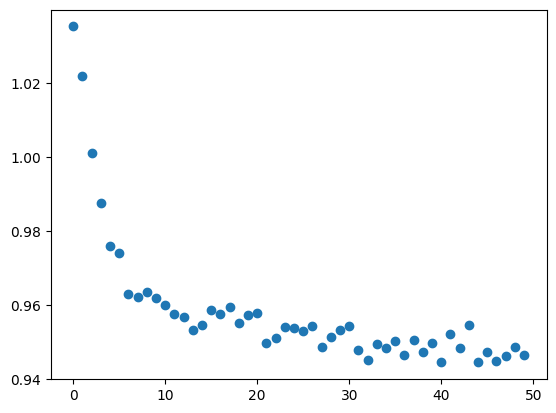

In [ ]:
plt.scatter(range(epochs), [l/y_train.shape[0] for l in losses])

In [ ]:
evalulate_model(pt_model, test_loader)

Test accuracy = 81.56424581005587 %


In [ ]:
diff = pd.DataFrame({
    'preds': (pt_model(X_test_tensors).squeeze() > 0.5).numpy().astype(np.long),
    'labels': y_test_tensors.numpy().astype(np.long),
})
sum(abs(diff['preds']-diff['labels']))
# plt.scatter(len(diff), diff['preds']-diff['labels'])

33

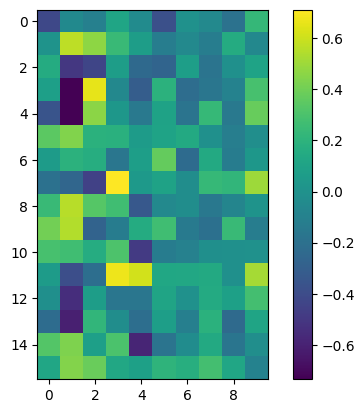

In [ ]:
input_weights = pt_model.model[0].weight.data.detach().numpy()
# plt.figure(figsize=(4,3))
plt.imshow(input_weights)
plt.colorbar()
plt.show()

this looks more consistent than the keras plot. It is obvious 2nd feature (Sex) is most prominent, followed by 3rd (Age).

In [ ]:
X.columns[input_weights.sum(axis=0).argsort()[::-1]]

Index(['Embarked_S', 'Embarked_U', 'Embarked_C', 'Embarked_Q', 'Age', 'Parch',
       'Fare', 'SibSp', 'Sex', 'Pclass'],
      dtype='object')

In [ ]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Embarked_U'],
      dtype='object')

## Visualise histogram

Text(0.5, 1.0, 'activation distribution')

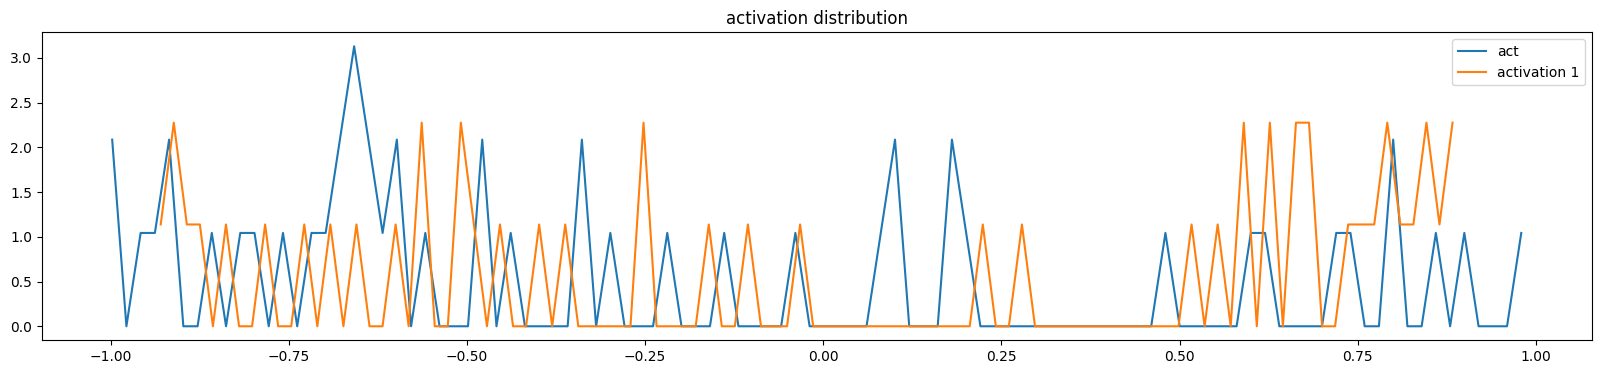

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for name, act in pt_model.activations.items():
  hy, hx = torch.histogram(act.cpu(), density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(name)
plt.legend(legends)
plt.title('activation distribution')

Text(0.5, 1.0, 'gradient distribution')

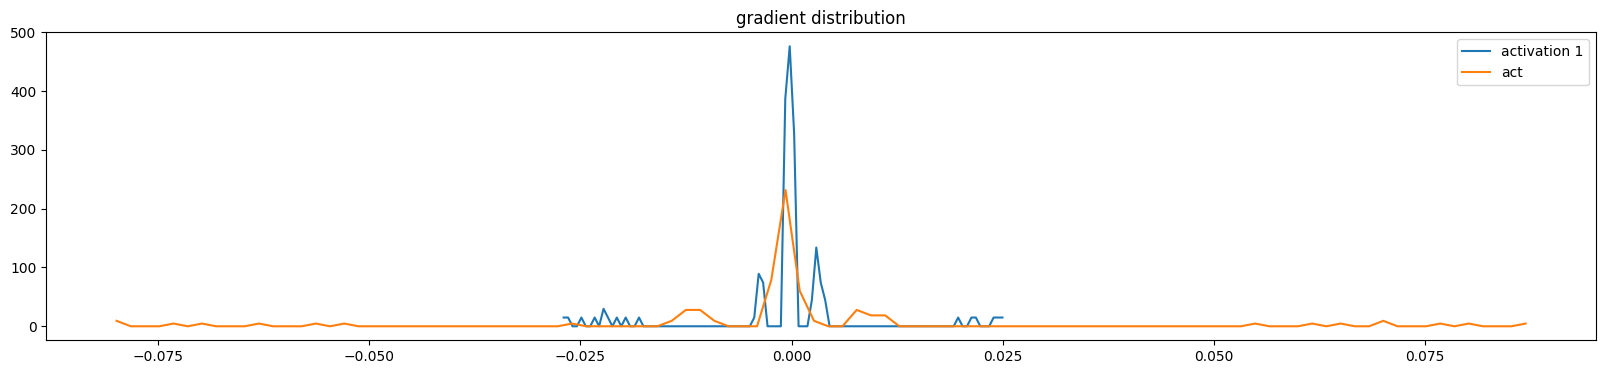

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for name, grad in pt_model.gradients.items():
  hy, hx = torch.histogram(grad.cpu(), density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(name)
plt.legend(legends)
plt.title('gradient distribution')

## Using Ray Tune
[https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html]

In [ ]:
import tempfile
from pathlib import Path
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

epochs = 100
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

X_train_tensors = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train.values, dtype=torch.int32)
X_test_tensors = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test.values, dtype=torch.int32)

def build_loaders(config):
  batch_size = int(config['batch_size'])
  train_loader = DataLoader(TensorDataset(X_train_tensors, y_train_tensors),
                            batch_size=batch_size,
                            shuffle=True)
  test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors),
                           batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

def build_rtmodel(config):
  model = PtModel(units=config['units'],
                  activation=config['activation'],
                  dr=config['dr'])

  # use GPU if available
  device = 'cpu'
  if torch.cuda.is_available():
    device = 'cuda:0'
    if torch.cuda.device_count() > 1:
      model = nn.DataParallel(model)
  model.to(device)

  return model

def train_rtmodel(config):
  train_loader, test_loader = build_loaders(config)
  model = build_rtmodel(config)

  criterion = nn.CrossEntropyLoss()

  if config['optimiser'] == 'adam':
    optimiser = optim.Adam(model.parameters(), lr=config['lr'])
  elif config['optimiser'] == 'sgd':
    optimiser = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
  else:
    optimiser = optim.RMSprop(model.parameters(), lr=config['lr'])

  checkpoint = get_checkpoint()
  if checkpoint:
    with checkpoint.as_directory() as checkpoint_dir:
      data_path = Path(checkpoint_dir) / "data.pkl"
      with open(data_path, "rb") as fp:
        checkpoint_state = pickle.load(fp)
      start_epoch = checkpoint_state["epoch"]
      model.load_state_dict(checkpoint_state["net_state_dict"])
      optimiser.load_state_dict(checkpoint_state["optimizer_state_dict"])
  else:
    start_epoch = 0

  for epoch in range(epochs):
    model.train()

    for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      optimiser.zero_grad()
      preds = model(X_batch).squeeze()
      loss = criterion(preds, y_batch.float())
      loss.backward()
      optimiser.step()

    # report loss to Ray Tune
    # train.report(loss=loss.item())

    # valiation loss
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(test_loader, 0):
      with torch.no_grad():
        X_val, y_val = data
        X_val, y_val = X_val.to(device), y_val.to(device)

        preds = (model(X_val).squeeze() > 0.5).float()
        total += y_val.size(0)
        correct += (preds==y_val.float()).sum().item()

        loss = criterion(preds, y_val.float())
        val_loss += loss.cpu().numpy()
        val_steps += 1

    # save checkpoint results for epoch
    checkpoint_data = {
        "epoch": epoch,
        "net_state_dict": model.state_dict(),
        "optimizer_state_dict": optimiser.state_dict(),
    }
    with tempfile.TemporaryDirectory() as checkpoint_dir:
      data_path = Path(checkpoint_dir) / "data.pkl"
      with open(data_path, "wb") as fp:
        pickle.dump(checkpoint_data, fp)

      checkpoint = Checkpoint.from_directory(checkpoint_dir)
      train.report({
          'loss': val_loss / val_steps,
          'accuracy': correct / total
      }, checkpoint=checkpoint)
  print("Finishing training")

def test_rtmodel(model, device="cpu"):
  model.eval()
  test_loader = DataLoader(TensorDataset(X_test_tensors, y_test_tensors),
                           batch_size=4, shuffle=False)
  correct = 0
  total = 0
  with torch.no_grad():
    for X_test, y_test in test_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      preds = (model(X_test).squeeze() > 0.5).float()
      total += y_test.size(0)
      correct += (preds==y_test.float()).sum().item()

  return correct/total


In [ ]:
config = {
    "units": tune.choice([[8], [32], [64]]),
    "optimiser": tune.choice(["adam", "sgd", "rmsprop"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16, 32, 64]),
    "dr": tune.choice([0.0, 0.2, 0.5]),
    "activation": tune.choice([nn.ReLU, nn.Tanh]),
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=2,
    grace_period=1,
    reduction_factor=2
)
analyse = tune.run(
    train_rtmodel,
    resources_per_trial={"cpu": 2, "gpu": 0},
    config=config, num_samples=3, scheduler=scheduler)

best_trial = analyse.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")


2025-03-31 05:05:48,331	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+----------------------------------------------------------------------+
| Configuration for experiment     train_rtmodel_2025-03-31_05-05-48   |
+----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator               |
| Scheduler                        AsyncHyperBandScheduler             |
| Number of trials                 3                                   |
+----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_rtmodel_2025-03-31_05-05-48

Trial status: 3 PENDING
Current time: 2025-03-31 05:05:48. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------------------------------------------------+
| Trial name                  status     units     optimiser             lr     batch_size     dr   activation           |
+-----------------------------------

(train_rtmodel pid=40011) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_rtmodel_2025-03-31_05-05-48/train_rtmodel_cf35d_00000_0_activation=ref_ph_bcab2133,batch_size=64,dr=0.0000,lr=0.0070,optimiser=sgd,units=32_2025-03-31_05-05-48/checkpoint_000000)
(train_rtmodel pid=40011) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_rtmodel_2025-03-31_05-05-48/train_rtmodel_cf35d_00000_0_activation=ref_ph_bcab2133,batch_size=64,dr=0.0000,lr=0.0070,optimiser=sgd,units=32_2025-03-31_05-05-48/checkpoint_000001)



Trial train_rtmodel_cf35d_00001 started with configuration:
+-----------------------------------------------------------------+
| Trial train_rtmodel_cf35d_00001 config                          |
+-----------------------------------------------------------------+
| activation                                 ...activation.ReLU'> |
| batch_size                                                   16 |
| dr                                                           0. |
| lr                                                      0.01835 |
| optimiser                                               rmsprop |
| units                                                       [8] |
+-----------------------------------------------------------------+

Trial train_rtmodel_cf35d_00001 finished iteration 1 at 2025-03-31 05:06:05. Total running time: 17s
+--------------------------------------------------------------+
| Trial train_rtmodel_cf35d_00001 result                       |
+--------------------------

(train_rtmodel pid=40120) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_rtmodel_2025-03-31_05-05-48/train_rtmodel_cf35d_00001_1_activation=ref_ph_8cecdf80,batch_size=16,dr=0.0000,lr=0.0183,optimiser=rmsprop,units=8_2025-03-31_05-05-48/checkpoint_000000)
(train_rtmodel pid=40120) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_rtmodel_2025-03-31_05-05-48/train_rtmodel_cf35d_00001_1_activation=ref_ph_8cecdf80,batch_size=16,dr=0.0000,lr=0.0183,optimiser=rmsprop,units=8_2025-03-31_05-05-48/checkpoint_000001)



Trial train_rtmodel_cf35d_00002 started with configuration:
+-----------------------------------------------------------------+
| Trial train_rtmodel_cf35d_00002 config                          |
+-----------------------------------------------------------------+
| activation                                 ...activation.Tanh'> |
| batch_size                                                   16 |
| dr                                                          0.2 |
| lr                                                      0.05915 |
| optimiser                                               rmsprop |
| units                                                      [64] |
+-----------------------------------------------------------------+


(train_rtmodel pid=40224) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_rtmodel_2025-03-31_05-05-48/train_rtmodel_cf35d_00002_2_activation=ref_ph_bcab2133,batch_size=16,dr=0.2000,lr=0.0592,optimiser=rmsprop,units=64_2025-03-31_05-05-48/checkpoint_000000)
2025-03-31 05:06:13,944	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_rtmodel_2025-03-31_05-05-48' in 0.0068s.



Trial train_rtmodel_cf35d_00002 finished iteration 1 at 2025-03-31 05:06:13. Total running time: 25s
+--------------------------------------------------------------+
| Trial train_rtmodel_cf35d_00002 result                       |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000000 |
| time_this_iter_s                                     1.53287 |
| time_total_s                                         1.53287 |
| training_iteration                                         1 |
| accuracy                                             0.73743 |
| loss                                       15.85802173614502 |
+--------------------------------------------------------------+
Trial train_rtmodel_cf35d_00002 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_rtmodel_2025-03-31_05-05-48/train_rtmodel_cf35d_00002_2_activation=ref_ph_bcab2133,batch_size=16,dr=0.2000,lr=0.0592,optimiser=rmsprop,units=64_20

(train_rtmodel pid=40224) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_rtmodel_2025-03-31_05-05-48/train_rtmodel_cf35d_00002_2_activation=ref_ph_bcab2133,batch_size=16,dr=0.2000,lr=0.0592,optimiser=rmsprop,units=64_2025-03-31_05-05-48/checkpoint_000001)


In [ ]:
analyse.get_best_checkpoint(best_trial, mode="min").to_directory()

'/tmp/checkpoint_tmp_c1b5050233684d43831af9bd192e49c0'

In [ ]:
!ls /tmp/checkpoint_tmp_c1b5050233684d43831af9bd192e49c0

data.pkl


{'units': [8], 'optimiser': 'rmsprop', 'lr': 0.018345857166547398, 'batch_size': 16, 'dr': 0.0, 'activation': <class 'torch.nn.modules.activation.ReLU'>}


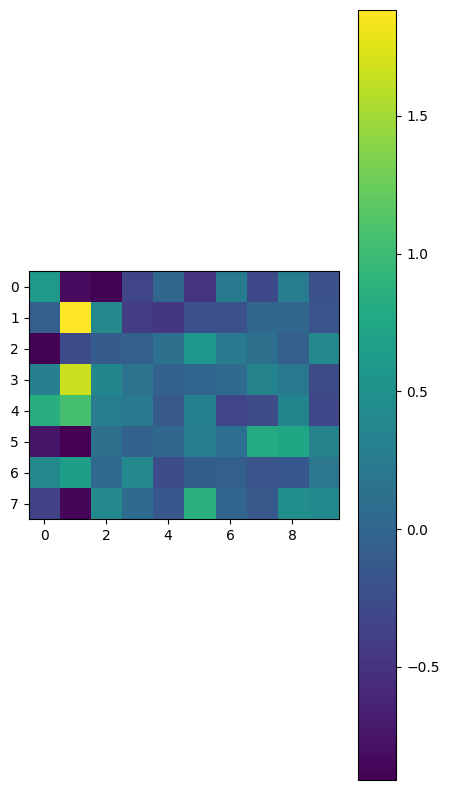

In [ ]:
best_checkpoint = analyse.get_best_checkpoint(best_trial, mode="min")
best_config = analyse.get_best_config(metric='loss', mode='min')
print(best_config)
best_ptmodel = PtModel(units=best_config['units'],
                      #  activation=best_config['activation'],
                       activation=nn.Tanh,
                       dr=best_config['dr'])

with best_checkpoint.as_directory() as checkpoint_dir:
  data_path = Path(checkpoint_dir) / "data.pkl"
  with open(data_path, "rb") as fp:
    best_checkpoint_data = pickle.load(fp)

best_ptmodel.load_state_dict(best_checkpoint_data["net_state_dict"])

input_weights = best_ptmodel.model[0].weight.data.detach().numpy()
plt.figure(figsize=(5,10))
plt.imshow(input_weights)
plt.colorbar()
plt.show()

In [ ]:
best_ptmodel

PtModel(
  (model): Sequential(
    (input layer): Linear(in_features=10, out_features=64, bias=True)
    (act): Tanh()
    (dropout): Dropout(p=0.2, inplace=False)
    (output layer): Linear(in_features=64, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [ ]:
test_acc = test_rtmodel(best_ptmodel, device)
# test_acc = evalulate_model(best_ptmodel)
print("Best trial test set accuracy: {}".format(test_acc))

Best trial test set accuracy: 0.8156424581005587


# check features survival rate

In [ ]:
df = pd.read_csv('./data/titanic.csv')
df['Age'] = df['Age'].fillna( df['Age'].median() )
df['Embarked'] = df['Embarked'].fillna('U')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
def col_stat(col):
  survival_count = df.query('Survived == 1')[col].value_counts().sort_index()
  mortal_count = df.query('Survived == 0')[col].value_counts().sort_index()
  survival_ratio = survival_count / (survival_count + mortal_count) * 100

  stats = pd.concat([survival_count, mortal_count, survival_ratio],
                          keys=['Survival Count', 'Mortality Count', 'Survaval Ratio %'], axis=1)
  stats = stats.fillna(0)
  print(stats)

  fig, (ax) = plt.subplots(1,1, figsize=(5,3))
  stats.plot(kind='bar', ax=ax)
  ax.set_xticklabels(stats.index, rotation=45)
  plt.show()
  return stats

        Survival Count  Mortality Count  Survaval Ratio %
Sex                                                      
female             233               81         74.203822
male               109              468         18.890815


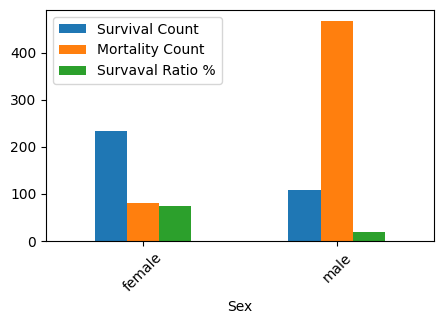

In [ ]:
stats = col_stat('Sex')

       Survival Count  Mortality Count  Survaval Ratio %
Age                                                     
0.42              1.0              0.0               0.0
0.67              1.0              0.0               0.0
0.75              2.0              0.0               0.0
0.83              2.0              0.0               0.0
0.92              1.0              0.0               0.0
...               ...              ...               ...
66.00             0.0              1.0               0.0
70.00             0.0              2.0               0.0
70.50             0.0              1.0               0.0
71.00             0.0              2.0               0.0
74.00             0.0              1.0               0.0

[88 rows x 3 columns]


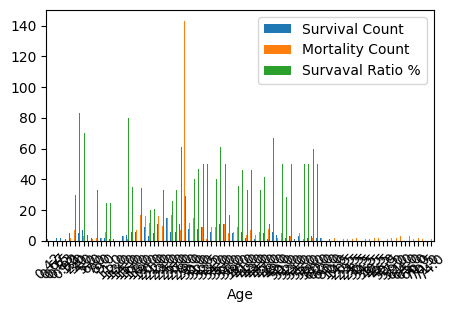

In [ ]:
stats = col_stat('Age')

          Survival Count  Mortality Count  Survaval Ratio %
Embarked                                                   
C                     93             75.0         55.357143
Q                     30             47.0         38.961039
S                    217            427.0         33.695652
U                      2              0.0          0.000000


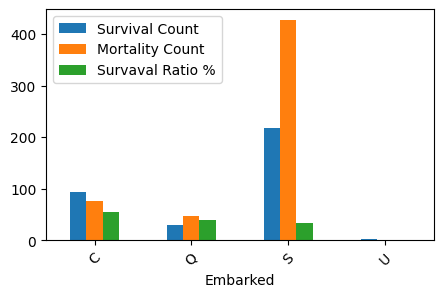

In [ ]:
stats = col_stat('Embarked')

       Survival Count  Mortality Count  Survaval Ratio %
SibSp                                                   
0               210.0              398         34.539474
1               112.0               97         53.588517
2                13.0               15         46.428571
3                 4.0               12         25.000000
4                 3.0               15         16.666667
5                 0.0                5          0.000000
8                 0.0                7          0.000000


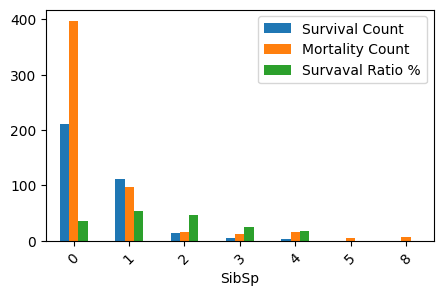

In [ ]:
stats = col_stat('SibSp')

       Survival Count  Mortality Count  Survaval Ratio %
Parch                                                   
0               233.0              445         34.365782
1                65.0               53         55.084746
2                40.0               40         50.000000
3                 3.0                2         60.000000
5                 1.0                4         20.000000
4                 0.0                4          0.000000
6                 0.0                1          0.000000


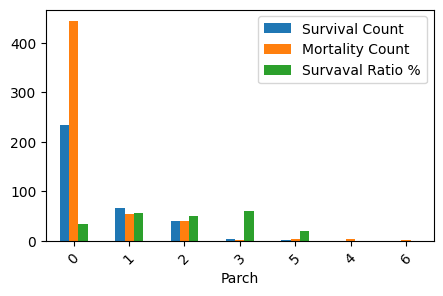

In [ ]:
stats = col_stat('Parch')

          Survival Count  Mortality Count  Survaval Ratio %
Fare                                                       
0.0000               1.0             14.0          6.666667
6.9750               1.0              1.0         50.000000
7.1417               1.0              0.0          0.000000
7.2250               3.0              9.0         25.000000
7.2292               4.0             11.0         26.666667
...                  ...              ...               ...
69.5500              0.0              7.0          0.000000
73.5000              0.0              5.0          0.000000
77.2875              0.0              2.0          0.000000
211.5000             0.0              1.0          0.000000
221.7792             0.0              1.0          0.000000

[248 rows x 3 columns]


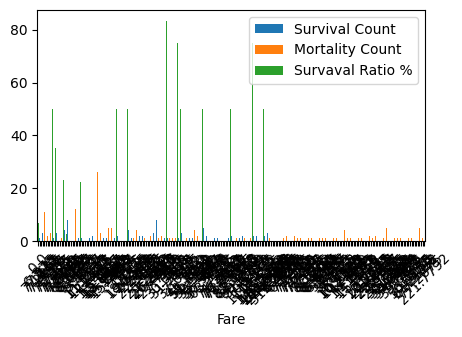

In [ ]:
stats = col_stat('Fare')